In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors

In [2]:
FILEPATH_USERS      = "datasets/BX-Users.csv"
FILEPATH_BOOKS      = "datasets/BX-Books.csv"
FILEPATH_RATINGS    = "datasets/BX-Book-Ratings.csv"

# dtype found through Notepad++
df_users    = pd.read_csv(FILEPATH_USERS, sep=";", header=[0], encoding="ANSI")
df_books    = pd.read_csv(FILEPATH_BOOKS , sep=";", usecols=["ISBN","Book-Title","Book-Author","Year-Of-Publication","Publisher","Image-URL-L"], encoding="ANSI", dtype="str")
df_ratings  = pd.read_csv(FILEPATH_RATINGS, sep=";", header=[0], encoding= "ANSI") #"UTF-8", encoding_errors="replace")

Now let's curate the dataset

df_users shape is (278858, 3)
<bound method NDFrame.head of         User-ID                            Location   Age
0             1                  nyc, new york, usa   NaN
1             2           stockton, california, usa  18.0
2             3     moscow, yukon territory, russia   NaN
3             4           porto, v.n.gaia, portugal  17.0
4             5  farnborough, hants, united kingdom   NaN
...         ...                                 ...   ...
278853   278854               portland, oregon, usa   NaN
278854   278855  tacoma, washington, united kingdom  50.0
278855   278856           brampton, ontario, canada   NaN
278856   278857           knoxville, tennessee, usa   NaN
278857   278858                dublin, n/a, ireland   NaN

[278858 rows x 3 columns]>
There are 1510 Locations with other than 2 ','
an example of those locations:
        User-ID                                           Location   Age
435         436            ivanhoe, melbourne, victoria, australi

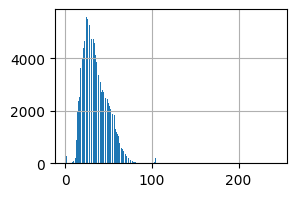

Min and max age is: 7.0 95.0


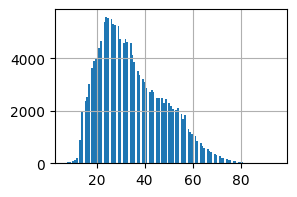

Final df_users shape is (164708, 3)


In [3]:
######################################
##  df_users
######################################

print("df_users shape is", df_users.shape)
print(df_users.head)


##################### User-ID column
# check if any USER-ID's aren't duplicated
assert len(df_users) == len(df_users["User-ID"].unique()), "Different number of user indexes than the number of users"


##################### Location column
# all Location's are in the form "city, region, country" -> look for strings with other than two ","
def check_string(string, count=2):
    """True if the input string contains exactly 2 ",", False otherwise"""
    return string.count(",") == count

print("There are", np.sum(1 - df_users["Location"].apply(check_string)), "Locations with other than 2 ','")
print("an example of those locations:")
print(df_users.iloc[np.where(1 - df_users["Location"].apply(check_string) == 1)])

# now check and correct strings with exactly one ","
def check_string_1(string, count=1):
    """True if the input string contains exactly 1 ",", False otherwise"""
    return string.count(",") == count

print("There are", np.sum(df_users["Location"].apply(check_string_1)), "Locations with 1 ','")
print(df_users.iloc[np.where(df_users["Location"].apply(check_string_1) == 1)])
#-> apparently the only case was "st. louis, missouri", let's add "usa"
df_users.at[np.where(df_users["Location"].apply(check_string_1) == 1)[0][0], "Location"] = "st. louis, missouri, usa"

# now check and correct strings with zero ","
def check_string_0(string, count=0):
    """True if the input string contains exactly no ",", False otherwise"""
    return string.count(",") == count

print("There are", np.sum(df_users["Location"].apply(check_string_0)), "Locations with 0 ','")
print(df_users.iloc[np.where(df_users["Location"].apply(check_string_0) == 1)])
#-> lawrenceville corresponds to multiple locations, let's remove it
df_users = df_users.drop(np.where(df_users["Location"].apply(check_string_0) == 1)[0][0])
df_users = df_users.reset_index(drop=True)

# "country" needs to be of length of at least 2 characters
def string_country_lenght(string):
    """
    input: string in the form "XX, YY, ZZ" (needs at least a single comma)
    output: True if len(ZZ) is at least 2, otherwise False
    We would like to catch botchered country names
    """
    comma_indices = [ind for ind, i in enumerate(string) if i==","]
    return len(string) > comma_indices[-1] + 3

print("There are", np.sum(1 - df_users["Location"].apply(string_country_lenght)), "botchered country names")
print(df_users.iloc[np.where(1 - df_users["Location"].apply(string_country_lenght) == 1)])
df_users = df_users.drop(np.where(1 - df_users["Location"].apply(string_country_lenght) == 1)[0])
df_users = df_users.reset_index(drop=True)
print("There are", np.sum(1 - df_users["Location"].apply(string_country_lenght)), "botchered country names")


# Let's change the Location column only into "Country", since even if there are more ",", the last one is always the country
def modify_location(string):
    """
    input: string in the form "XX, YY, ZZ" (can have more than 2 ",")
    returs: the substring that follows the last ", " in the input string, eg. "ZZ" in the example
    For reduction of the "Location" collumn only into a "Country" column
    """
    comma_indices = [ind for ind, i in enumerate(string) if i==","]
    assert len(comma_indices) > 1, "Despite all filtering somehow a string without a ',' made it into def modify_location"
    assert len(string) > comma_indices[-1] + 2, "Some country name is absent (string ends with a comma and possibly a space)"
    return string[comma_indices[-1] + 2 : ]

df_users["Country"] = df_users["Location"].apply(modify_location)
print(df_users)
print("There are", len(df_users["Country"].unique()), "unique entries in the 'Country' column.")
# Let's remove "Location" column - way too specific, of no use anymore now that we have "Country"
df_users = df_users.drop(labels="Location", axis="columns")
#-> Let's prune the country column, there are entries like "universe" and "u. s. of a."
country_count = df_users["Country"].value_counts()
df_users = df_users[df_users["Country"].isin(country_count[country_count >= 2].index)]
print("After removing low-count Countries, there are", len(df_users["Country"].unique()), "unique entries in the 'Country' column.")
print(df_users)

##################### Age column
# Let's plot the histogram, remove outliers
fig, ax = plt.subplots(figsize=(3, 2))
hist = df_users.Age.hist(bins="auto")
plt.show()

# -> let's remove all users with their age not in range (7, 95), and anything with NaN values
df_users["Age"] = pd.to_numeric(df_users["Age"])
df_users = df_users.drop(df_users[(df_users["Age"] > 95) | (df_users["Age"] < 7)].index)
df_users.dropna(how="any", inplace = True)
df_users = df_users.reset_index(drop=True)
print("Min and max age is:", np.min(df_users["Age"].unique()), np.max(df_users["Age"].unique()))

fig, ax = plt.subplots(figsize=(3, 2))
hist = df_users.Age.hist(bins="auto")
plt.show()
print("Final df_users shape is", df_users.shape)


(271379, 6)
              ISBN                                         Book-Title  \
0       0195153448                                Classical Mythology   
1       0002005018                                       Clara Callan   
2       0060973129                               Decision in Normandy   
3       0374157065  Flu: The Story of the Great Influenza Pandemic...   
4       0393045218                             The Mummies of Urumchi   
...            ...                                                ...   
271374  0440400988                         There's a Bat in Bunk Five   
271375  0525447644                            From One to One Hundred   
271376  006008667X  Lily Dale : The True Story of the Town that Ta...   
271377  0192126040                        Republic (World's Classics)   
271378  0767409752  A Guided Tour of Rene Descartes' Meditations o...   

                 Book-Author Year-Of-Publication  \
0         Mark P. O. Morford                2002   
1      

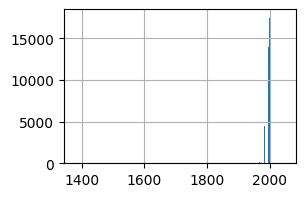

16393


In [4]:
######################################
##  df_books
######################################

print(df_books.shape)
print(df_books)

##################### Year-Of-Publication
print(df_books["Year-Of-Publication"].unique())
df_books["Year-Of-Publication"] = pd.to_numeric(df_books["Year-Of-Publication"], errors="coerce")
df_books.dropna(how="any", inplace = True)
df_books = df_books[df_books["Year-Of-Publication"] != 0.]
df_books = df_books.reset_index(drop=True)
print(df_books["Year-Of-Publication"].unique())
print(df_books.shape)
fig, ax = plt.subplots(figsize=(3, 2))
hist = df_books["Year-Of-Publication"].hist(bins="auto")
plt.show()

##################### Publisher
print(len(df_books["Publisher"].unique())) #NaN values already removed with .dropna in Year-Of-Publication

         User-ID         ISBN  Book-Rating
0         276725   034545104X            0
1         276726   0155061224            5
2         276727   0446520802            0
3         276729   052165615X            3
4         276729   0521795028            6
...          ...          ...          ...
1149775   276704   1563526298            9
1149776   276706   0679447156            0
1149777   276709   0515107662           10
1149778   276721   0590442449           10
1149779   276723  05162443314            8

[1149780 rows x 3 columns]
There are 716109 ratings with 0 -> without an actual value
        User-ID        ISBN  Book-Rating
0        276729  052165615X            3
1        276729  0521795028            6
2        276747  0060517794            9
3        276747  0671537458            9
4        276747  0679776818            8
...         ...         ...          ...
258718   276681  0446677450            8
258719   276681  0609806491            7
258720   276681  1931333246 

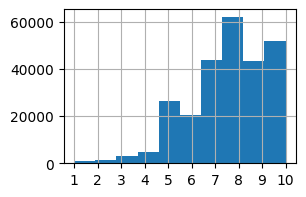

In [5]:
######################################
##  df_ratings
######################################


print(df_ratings)

# Let's add there "Book-Title" instead of "ISBN"
#df_ratings = df_ratings.merge(df_books[["ISBN", "Book-Title"]], on="ISBN")
#df_ratings = df_ratings.drop(labels="ISBN", axis="columns")

# Let's check how many 0's are there in Book-Rating - we don't want these
print("There are", len(df_ratings[df_ratings["Book-Rating"] == 0]), "ratings with 0 -> without an actual value")
df_ratings = df_ratings[df_ratings["Book-Rating"] != 0]
df_ratings = df_ratings.reset_index(drop=True)

# Remove ratings that feature removed users or books
df_ratings = df_ratings[df_ratings["User-ID"].isin(df_users["User-ID"])].reset_index(drop=True)
df_ratings = df_ratings[df_ratings["ISBN"].isin(df_books["ISBN"])].reset_index(drop=True)
print(df_ratings)
fig, ax = plt.subplots(figsize=(3, 2))
hist = df_ratings["Book-Rating"].hist(bins=10)
ax.set_xticks(np.linspace(1, 10, 10))
plt.show()

In [6]:
######################################
##  creating evaluation_matrix
######################################
# needs to be smaller than a certain treshold

NUM_USERS = 40
user_count = df_ratings["User-ID"].value_counts()
print("There is", len(user_count[user_count >= NUM_USERS]), "users that rated at least", NUM_USERS, "books")
#df_ratings = df_ratings[df_ratings["User-ID"].isin(user_count[user_count > NUM_RATINGS].index)].reset_index(drop=True)

NUM_BOOKS = 7
book_count = df_ratings["ISBN"].value_counts()
print("There is", len(book_count[book_count >= NUM_BOOKS]), "books that have more or equal than", NUM_BOOKS, "ratings")

# Let's create a new, smaller ratings dataframe
df_ratings_cropped = df_ratings[df_ratings["User-ID"].isin(user_count[user_count >=NUM_USERS].index)]
df_ratings_cropped = df_ratings_cropped[df_ratings_cropped["ISBN"].isin(book_count[book_count >=NUM_BOOKS].index)]
print("The cropped dataset has", len(df_ratings_cropped), "entries")

#Let's transform the dataframe into a matrix. 
evaluation_matrix = df_ratings_cropped.pivot(index="ISBN", columns="User-ID", values="Book-Rating")
evaluation_matrix = evaluation_matrix.fillna(value=0)
print(evaluation_matrix.shape)
print("That results in", np.round(100 * np.sum((evaluation_matrix != 0).to_numpy()) / (evaluation_matrix.shape[0] * evaluation_matrix.shape[1]), 3), "percent of non zero elements in the  matrix")

# Let's get rid of multilevel indexing
# evaluation_matrix = evaluation_matrix.rename_axis(None)
# To check indexes are alright
# assert len(df_ratings_cropped["ISBN"].unique()) == len(evaluation_matrix.index)


There is 1172 users that rated at least 40 books


There is 5552 books that have more or equal than 7 ratings
The cropped dataset has 38346 entries
(5433, 1167)
That results in 0.605 percent of non zero elements in the  matrix


In [7]:
######################################
##  building the model
######################################
# knn the best variant? -> No objective way to evaluate the data, does not require a more complicated approach

model = neighbors.NearestNeighbors(n_neighbors=5, algorithm="brute")
model.fit(evaluation_matrix)

NearestNeighbors(algorithm='brute')

In [8]:
# Now that we know it works, let's do it so that we can use "Book-Title" instead of "ISBN" and that "Age" and "Country" can be used using a custom metric
EXAMPLE = df_ratings_cropped.iloc[0]["ISBN"] # "0307302636"
display(df_books[df_books["ISBN"] == EXAMPLE])
TITLE = df_books[df_books["ISBN"] == EXAMPLE]["Book-Title"].iloc[0] # "Billy"

corresponding_ISBN = df_books[df_books["Book-Title"] == TITLE]["ISBN"].iloc[0]
print(corresponding_ISBN)

prediction = model.kneighbors(evaluation_matrix.loc[[corresponding_ISBN]])
print(prediction[1][0])

def get_prediction_names(matrix_indices, evaluation_matrix=evaluation_matrix, df_books=df_books):
    """
    Recieves:
        a list of indices of nearest neighbors of the input vector (including the input vector index itself)
        evaluation_matrix - to get "ISBN" corresponding to the indices
        df_books dataframe - to get "Book-Title corresponding to those "ISBN"s
    Returns a dataframe with names of those books
    """
    isbns = evaluation_matrix.iloc[matrix_indices].index
    return df_books[df_books["ISBN"].isin(isbns)] # ["Book-Title"].tolist()


display(get_prediction_names(prediction[1][0][1:]))

# Custom metric - first we need to be able to get the "User-ID" indices corresponding to the affected users. I consider a 10 year interval around the AGE value
COUNTRY = "mexico"
AGE = 25

target_users = df_users[((df_users["Age"] <= AGE + 5)  & (df_users["Age"] >= AGE - 5)) | (df_users["Country"] == COUNTRY)]

target_columns = evaluation_matrix.columns.isin(target_users["User-ID"]) # already a np.array, nice :D

def custom_metric(v1, v2, target_columns=target_columns, factor=3):
    """
    Used when evaluating the nearest neighbors. Using a custom one because we want to increase the influence of chosen users
    The metric used will be Minkowski for p=2 (Euclidean)
    Recieves: 
        v1, v2          ... vectors from the evaluation_matrix space
        target_columns  ... columns we want to increase the influence of
        factor          ... the factor by which will the NON-target columns will be multiplied
    Returns:
        the weighted distance between v1 and v2
    """
    weight_vector = 1 + (factor - 1) * (1 - target_columns)
    return np.sqrt(np.sum(np.abs(v1 - v2)**2 * weight_vector)) # tbh np.sqrt is not needed, but let's keep it consistent


# Let's test our metric!
model_2 = neighbors.NearestNeighbors(n_neighbors=5, algorithm="brute", metric=custom_metric)
model_2.fit(evaluation_matrix)
prediction = model_2.kneighbors(evaluation_matrix.loc[[corresponding_ISBN]])
print("#" * 40)
display(get_prediction_names(prediction[1][0][1:]))

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
30959,0307302636,The Grand and Wonderful Day (Little Golden Book),Mary Packard,1995.0,Western Publishing Company,http://images.amazon.com/images/P/0307302636.0...


0307302636
[ 649 4084 3573 4112 5278]


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
1222,0553572490,Vice,Jane Feather,1996.0,Bantam,http://images.amazon.com/images/P/0553572490.0...
5400,1882723007,Embraced by the Light,Betty J. Eadie,1992.0,Gold Leaf Press (MI),http://images.amazon.com/images/P/1882723007.0...
11672,0671795554,Remember When,Judith McNaught,1997.0,Pocket,http://images.amazon.com/images/P/0671795554.0...
16349,0671746065,The Hitchhiker's Guide to the Galaxy,Douglas Adams,1991.0,Pocket,http://images.amazon.com/images/P/0671746065.0...


########################################


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
6642,0743420373,The Millionaire Next Door: The Surprising Secr...,Thomas J. Stanley,2000.0,Pocket,http://images.amazon.com/images/P/0743420373.0...
16349,0671746065,The Hitchhiker's Guide to the Galaxy,Douglas Adams,1991.0,Pocket,http://images.amazon.com/images/P/0671746065.0...
17081,0446605336,My Sergei : A Love Story,E. M. Swift,1997.0,Warner Books,http://images.amazon.com/images/P/0446605336.0...
71484,0380812967,The Indiscretion,Judith Ivory,2001.0,Avon,http://images.amazon.com/images/P/0380812967.0...


In [9]:
######################################
##  save dataframes
######################################

# before we do that, let's also reduce the size of df_users and df_books - only a part of those books is used in evaluation_matrix
df_ratings_cropped.to_pickle("df_ratings_cropped.pkl")
df_users_reduced = df_users[df_users["User-ID"].isin(evaluation_matrix.columns)]
df_books_reduced = df_books[df_books["ISBN"].isin(evaluation_matrix.index)]

#evaluation_matrix.to_pickle("evaluation_matrix.pkl")
#df_users_reduced.to_pickle("df_users_reduced.pkl")
#df_books_reduced.to_pickle("df_books_reduced.pkl")

In [11]:
df_ratings_cropped.to_pickle("df_ratings_cropped.pkl")